# Project for the 'Programming for Data Analysys'
***

### Table of content
[1. Problem statement](#par1)<br>
[2. Define functions used for process analysis](#par2)<br>
[3. Simulate the data using``numpy.random`` package](#par3)<br>
[3.1 Simulate single variable](#par3.1)<br>
[3.1.1 Perfect process](#par3.1.1)<br>
[3.1.1 Simulate 'special causes'](#par3.1.2)<br>
[3.2 Simulate scrap ratio based on 10 dimensions](#par3.2)<br>
[4. Analise the data](#par4)<br>
<hr>

### Import all the packages

In [1]:
# import all the packackes used in the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min, norm

In [2]:
# Create the new instance of the numpy psudorandom numbers Generator
rng = np.random.default_rng()

<a id="par1"></a>
## 1. Problem statement


Variability in any manufacturing process can be divided into two distinct categories [1]: 
- Random or natural variability, which is naturally present in any process or system. This can be caused by machine vibration, natural changes in raw material hardness, errors in machine axis encoders etc. Process that has only natural variability is called statistically stable process
- Assignable or special cause variability. This variability is not inherent part of the process, and the sources of this variability can be identified and removed from the process.

In the Section 3.1.1. I will stimulate the result of a process that has only common causes of variability present. This type of process can be described with a normal distribution 
Distribution of a measurements of a single dimension in the stable manufacturing process (process that has no special causes) follows normal distribution.

In Section 3.1.2 I will be adding special (or assignable) sources of process variability. First I will add batch to batch variation caused by changes in the fixture setup, next variability caused by the cutting tool: differences in the tool size, tool wear and tool failure.

The following assumptions were made:
- Single manufacturing process step is modelled
- Each part has 10 dimensions that are independently measured
    - Some dimensions are correlated
- If any of the 10 dimensions is measured outside of the specified limit, part is scrapped
- Parts are manufactured in batches of 10

<a id="par2"></a>
## 2. Define functions used for process analysis

##### Define custom Histogram

In [3]:
def hist(data, label, lsl, usl, cp):
    # data - Array containing the data to display
    # label - label to use in the title
    # lsl, usl - Lower and Upper Service Limits
    # cp - theoretical process capability used to generate the data
    
    # Calculate number of Histogram bins using Sturge’s Rule
    # as per: https://www.statisticshowto.com/choose-bin-sizes-statistics/
    bins = int(np.round(np.log10(n)*3.322+1))

    fig, ax = plt.subplots(1, 1)
    
    # Create a histogram, capture count to calculate position of the USL and LCL labels
    count, bins, patches = ax.hist(data, bins, density=False, label=label, alpha=0.8)
    
    max_y = max(count)
    
    # Draw red vertical lines for upper and lower tolerances
    ax.axvline(usl, color='r', linestyle='dashed', linewidth=1)
    ax.axvline(lsl, color='r', linestyle='dashed', linewidth=1)
    # Add labels to the vertical lines
    # https://stackoverflow.com/questions/13413112/creating-labels-where-line-appears-in-matplotlib-figure
    # y position of the label calculated using the count of the hihgest bin and divided by 10
    ax.text(lsl, max_y/10, 'LSL',rotation=90)
    ax.text(usl, max_y/10, 'USL',rotation=90)
    
    # Draw Probability density function for normal distribution
    
    # Get limit of the X axis
    # https://stackoverflow.com/questions/26131607/matplotlib-get-ylim-values
    x_min, x_max = ax.get_xlim()
    
    # https://realpython.com/how-to-use-numpy-arange/
    x = np.arange(x_min, x_max, (x_max-x_min)/500. )
    
    # calculate PDF using scipi.stats package:
    y = norm.pdf(x, loc=data.mean(), scale=data.std())
    
    # calculate the max bin count to max pdf ration to use it as scaling factor for pdf:
    scale = max_y/max(y)
    
    # Plot pdf
    ax.plot(x, y*scale)
    
    # https://saralgyaan.com/posts/matplotlib-tutorial-in-python-chapter-5-filling-area-on-line-plots/
    ax.fill_between(x, 0, y*scale, color='red', where=(x<lsl), alpha=0.7 )
    ax.fill_between(x, 0, y*scale, color='red', where=(x>usl), alpha=0.7 )

    # define plot's parameters
    plt.rcParams["figure.figsize"] = [8, 4]
    plt.xlabel('Mmeasurements')
    plt.ylabel('Frequency of occurence')
    plt.title('Distribution of {} in a process with Cp={:.2}'.format(label, cp))
    plt.legend(['LSL', 'USL', 'PDF', label])
    plt.show()

##### Define SPC (Statistical Process Control) charts

In [4]:
# Define a function that will check if datapoints are violating any of the SPC rules
def spc_stats(dim, std_in=[], n=1):
    
    # Define DataFrame with one column 'Dim'
    data = pd.DataFrame({'Dim': dim})
    
    # Add column with moving range:
    # Calculated as per https://stackoverflow.com/questions/30673209/pandas-compare-next-row
    data['mR'] = data['Dim']-data['Dim'].shift(1)    
    
    # Add 'Reason' column
    data['Reason'] = 0    
    
    # use calculations for X-bar S chart if n>1
    if n>1:
        # Calculations for below parameters as per 'Implementing Six Sigma' Forrest W. Breyfogle III, p1059
        
        c4 = 4*(n-1)/(4*n-3)
        a3 = 3/(c4*np.sqrt(n))                
        b3 = 1-3/(c4*np.sqrt(2*(n-1)))
        b4 = 1+3/(c4*np.sqrt(2*(n-1))) 
        
        # use standard deviation array instead of moving range 
        data['variability'] = std_in
        
        #calculate mean of X-bar and standard deviation
        x_bar = np.mean(data['Dim'])
        mr_bar = np.mean(std_in)
        
        #calulcate upper and lower contol limits for X-bar and standard deviation
        ucl = x_bar+mr_bar*a3
        lcl = x_bar-mr_bar*a3
        
        mr_ucl = mr_bar*b4
        mr_lcl = mr_bar*b3
                                
        
    # use calculations for X mR chart
    else:
        # Set variability to moving range
        data['variability'] = data['mR']
    
        # calculate the mean of the variable
        x_bar = np.mean(data['Dim'])
        mr_bar = np.mean( np.abs(data['mR'][1:len(data['mR'])]))

        # Below calculations as per 'Implementing Six Sigma' Forrest W. Breyfogle III, p227
        # Calculate Upper and Lower Control Limits for X chart 
        ucl = x_bar+mr_bar*2.66
        lcl = x_bar-mr_bar*2.66

        # Calculate Upper Control Limits for mR chart (there is no lower CL for mR chart)
        mr_ucl = mr_bar+mr_bar*3.267          
    
    # Shewhart SPC control chart rules:
    # https://analyse-it.com/docs/user-guide/process-control/shewhart-control-chart-rules
    
    # Number of observation on the same side of the mean when the alarm is switched on (typically 8 or 9)
    n_side=8
    
    # Number of consecutive points steadily increasing or decreasing to switch the alarm (typically 6)
    n_drift = 6
    
    # Number of consecutive points are alternating up and down (typically 14)
    n_alter = 8
    
    # Initiate 'Reason' column with zeros
    # Each violation of the SPC rules will be added as a power of 2. At the end, 'Reason' column will be converted to binary string
    # This way, I can detect more than one SPC rule violation
    data['Reason'] = 0
    
    # Check for measurements aoutside the contro limits
    for index, row in data.iterrows():
        x = row[0]
        mr = row[1]
        
        if x>ucl or x<lcl:
            data.loc[index, 'Reason'] += 1
            
        if mr>mr_ucl:
            data.loc[index, 'Reason'] += 2
            
    
    # check if there ar at least 'n_side' points on the same side of the mean line
    
    # 1 if point is above x_bar, -1 if it's below
    data['xbar_side'] = np.sign(data['Dim'] - x_bar)

    # count running sum of last n_side ['xbar_side'] values
    data['sameside'] = data['xbar_side']
    for i in range(1, n_side):
        data['sameside'] =  data['sameside']  + data['xbar_side'].shift(i)
    
    data.loc[ np.abs(data['sameside'])==n_side , 'Reason'] += 4
    
    # Check for drifts in data: points are steadily increasing or decreasing
    
    data['delta_sign']=np.sign( data['mR'] )
    
    # count running sum of last n_side ['xbar_side'] values
    data['drift'] = data['delta_sign']
    for i in range(1, n_drift):
        data['drift'] =  data['drift'] + data['delta_sign'].shift(i)
    
    data.loc[ np.abs(data['drift'])==n_drift , 'Reason'] += 8
    
    # check for consecutive points are alternating up and down
    
    # column 'alter' will be 0 if 2 consecutive points alter in direction of change
    # and will be 2 if they both going up or down
    data['alter'] = np.abs(data['delta_sign'] + data['delta_sign'].shift(1) )
    
    # if there sum of the last n_alter rows of 'alter' column equal 0
    # Then that means that these points were alternating up and down for n_alter consecutive points
    data['sum_alter'] = data['alter']
    for i in range(1, n_alter):
        data['sum_alter'] =  data['sum_alter'] + data['alter'].shift(i)
    
    data.loc[ np.abs(data['sum_alter'])==0 , 'Reason'] += 16    
    
    # Translate the sum of reasons into binary string
    # as per: https://stackoverflow.com/questions/45018601/decimal-to-binary-in-dataframe-pandas
    data['Reason'] = data.Reason.apply(lambda x: format(int(x), '05b'))
    
    if n==1:
        return data[['Dim', 'variability', 'Reason']], x_bar, mr_bar, ucl, lcl, mr_ucl
    else:
        return data[['Dim', 'variability', 'Reason']], x_bar, mr_bar, ucl, lcl, mr_ucl, mr_lcl

##### Define XmR chart

In [5]:
# Basis for this code taken from: https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051

def xmr(data_in, n=0):
    # data_in - Array containing the data to display
    # n - show only last n measurements, if n=0, show all
    
    # Make sure n is greater than 0 and smaller than the lenght of the data array
    if n>0 and n<len(data_in):
        dim = data_in[-n:]
    else:
        dim = data_in
    
    # Find the points that are violating SPC rules and calculate the means and control limits
    data, x_bar, mr_bar, ucl, lcl, mr_ucl = spc_stats(dim)


    # Plot x and mR charts
    fig, axs = plt.subplots(2, figsize=(8,8), sharex=True)

    # X chart
    # Graph all the points 
    axs[0].plot(data['Dim'], linestyle='-', marker='o', color='black')

    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason'].str[-5]=="1"]['Dim'], linestyle="", marker='o', color='blue')     
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason'].str[-4]=="1"]['Dim'], linestyle="", marker='o', color='yellow')    
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason'].str[-3]=="1"]['Dim'], linestyle="", marker='o', color='orange')    
    
    # Add red dot where Dim is over UCL or under LCL
    axs[0].plot(data[data['Reason'].str[-1]=="1"]['Dim'], linestyle="", marker='o', color='red')    

    # Plot blue horizontal line at the process mean
    axs[0].axhline(x_bar, color='blue')

    # Plot red dotted lines at UCL and LCL
    axs[0].axhline(ucl, color = 'red', linestyle = 'dashed')
    axs[0].axhline(lcl, color = 'red', linestyle = 'dashed')

    # Set Chart title and axis labels
    axs[0].set_title('Individual Chart')
    axs[0].set(xlabel='Part', ylabel='Measurement')


    # mR chart
    # Graph all the points 
    axs[1].plot( np.abs(data['variability']), linestyle='-', marker='o', color='black')

    # Add red dot where Dim is over UCL
    axs[1].plot(data[data['Reason'].str[-2]=="1"]['variability'], linestyle="", marker='o', color='red')

    # Plot blue horizontal line at the mR mean
    axs[1].axhline(mr_bar, color='blue')

    # Plot red dotted line at UCL
    axs[1].axhline(mr_ucl, color='red', linestyle ='dashed')

    axs[1].set_ylim(bottom=0)
    axs[1].set_title('Moving Range Chart')
    axs[1].set(xlabel='Part', ylabel='Range')
    
    return data

##### Define X-Bar S chart (average X and standard deviation)

In [6]:
# Basis for this code taken from: https://towardsdatascience.com/quality-control-charts-guide-for-python-9bb1c859c051

def xBarS(data_in, col, n=0):
    # data_in - Pandas DataFrame containing the data to display
    # col - column from the data_in table to be displayed
    # n - optional, number of last datapoint to display; display all if not provided
    
    # specify average number of parts in lot, as the UCL and LCL values will depend on this
    avg_parts_in_lot = len(data_in)/len(data_in['Lot'].unique())
    
    # Calculate mean value pfor each lot
    dim = data_in[['Lot', col]].groupby('Lot').mean()
    std = data_in[['Lot', col]].groupby('Lot').std()
    
    # Find the points that are violating SPC rules and calculate the control limits
    alldata, x_bar, mr_bar, ucl, lcl, mr_ucl, mr_lcl = spc_stats(dim[col], std[col], avg_parts_in_lot)    
    
    # Make sure n is greater than 0 and smaller than the lenght of the data array
    if n>0 and n<len(dim):
        # Trim the number of displayed poinints to the last n:
        data = alldata[-n:]
        #dim = dim[-n:]    

    # Plot x and mR charts
    fig, axs = plt.subplots(2, figsize=(8,8), sharex=True)

    # X chart
    # Graph all the points 
    axs[0].plot(data['Dim'], linestyle='-', marker='o', color='black')

    
    # Add red dot when there are too many points on the same side of the mean
    
    axs[0].plot(data[data['Reason'].str[-5]=="1"]['Dim'], linestyle="", marker='o', color='blue')     
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason'].str[-4]=="1"]['Dim'], linestyle="", marker='o', color='yellow')    
    
    # Add red dot when there are too many points on the same side of the mean
    axs[0].plot(data[data['Reason'].str[-3]=="1"]['Dim'], linestyle="", marker='o', color='orange')    
    
    # Add red dot where Dim is over UCL or under LCL
    axs[0].plot(data[data['Reason'].str[-1]=="1"]['Dim'], linestyle="", marker='o', color='red')    

    # Plot blue horizontal line at the process mean
    axs[0].axhline(x_bar, color='blue')

    # Plot red dotted lines at UCL and LCL
    axs[0].axhline(ucl, color = 'red', linestyle = 'dashed')
    axs[0].axhline(lcl, color = 'red', linestyle = 'dashed')

    # Set Chart title and axis labels
    axs[0].set_title('X-Bar Chart for {}'.format(col))
    axs[0].set(xlabel='Lot number', ylabel='Measurement')


    # mR chart
    # Graph all the points 
    axs[1].plot( np.abs(data['variability']), linestyle='-', marker='o', color='black')

    # Add red dot where Dim is over UCL
    axs[1].plot(data[data['Reason'].str[-2]=="1"]['variability'], linestyle="", marker='o', color='red')

    # Plot blue horizontal line at the mR mean
    axs[1].axhline(mr_bar, color='blue')

    # Plot red dotted line at UCL and LCL
    axs[1].axhline(mr_ucl, color='red', linestyle ='dashed')
    axs[1].axhline(mr_lcl, color='red', linestyle ='dashed')

    axs[1].set_ylim(bottom=0)
    axs[1].set_title('Standard deviation Chart for {}'.format(col))
    axs[1].set(xlabel='Part', ylabel='Range')
    
    # return all the data points: lot with respective average, standard deviation within a lot and the violated SPC rules (if any)
    # Use all the data points, not only the ones that are trmmed for display
    return alldata

<a id="par3"></a>
## 3. Simulate the data using ```numpy.random``` package

<a id="par3.1"></a>
### 3.1 Simulate single variable

<a id="par3.1.1"></a>
#### 3.1.1 Process with no special cause variability

##### Define Dim1 attributes

Process capability:

$$
C_{p}=\frac{USL-LSL}{6\sigma}
$$

Given the process capability and upper and lower service limits, we can calculate the underlying process standard deviation:


$$
\sigma=\frac{USL-LSL}{6 C_{p}}
$$

##### Define process parameters

In [7]:
# Nominal dimension
mean = 9.5
# Upper and Lower tollerances
lsl, usl = 9.4, 9.6
# Process capability
cp = 2.
# Number of lots
nr_lots = 20
# Parts in the lot 
nr_in_lot = 10
# Total number of parts
n = nr_lots*nr_in_lot

In [8]:
# Simulate the measurements of single dimenension using normal distribution
# ccv stands for common cause variation
dim1 = pd.DataFrame({'ccv': rng.normal(mean, (usl-lsl)/(6*cp) , n)})

##### Show distribution of dim1 using Histogram

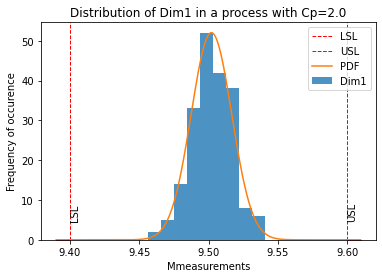

In [9]:
hist(dim1, 'Dim1', lsl, usl, cp)

##### Check Dim1 with Statistical Process Control charts

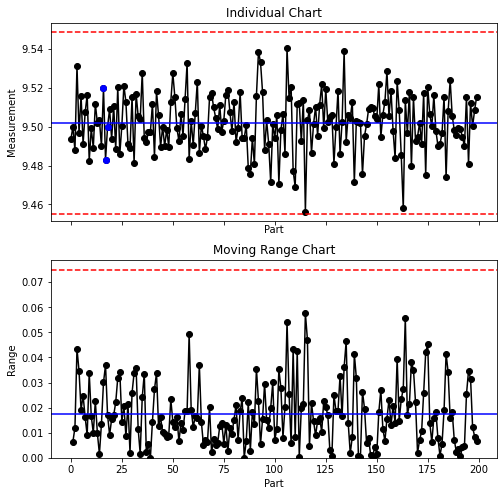

In [10]:
o = xmr(dim1.loc[:,'ccv'])

##### Process not centered at nominal

More realistic scenarion would be a situation where the manufacturing process is not perfectly centered on the nominal value. This can be caused by:
- Lack of machine calibration
- Poor process design

In [11]:
# Simulate the effect of proces not being centered at the nominal
# The mean of such process would be pooled from normal distribution:

proc_mean=rng.normal(mean, (usl-lsl)/6)

dim1['ccv'] = rng.normal(proc_mean, (usl-lsl)/(6*cp) , n)

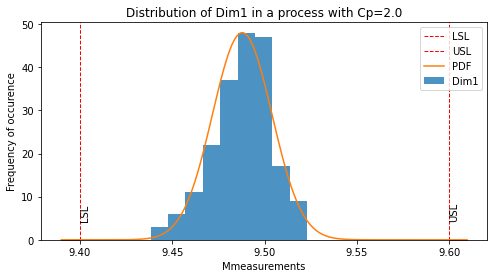

In [12]:
# As seen on the histogram plot, process without special causes variability is alredy not centered perfectly between upper and lower service limits
hist(dim1['ccv'], 'Dim1', lsl, usl, cp)

<a id="par3.1.2"></a>
#### 3.1.2 Simulate 'special causes'

##### Variation between the batches

Vatiation between the batches can be casued by:
- difrences in the fixture setup
- changes in the raw material (material hardness, forging size etc)

Distribution of batch-to-batch variation is normal.

In [13]:
# define the ratio of batch-to-batch standard deviation to the dimension tolerance
# The larger the number, the smallest the effect of this special cause 
btb_sd_ratio = 20

# create a array with adjustment for each lot
lots = rng.normal(0, (usl-lsl)/btb_sd_ratio , nr_lots)

# add the same adjustment for each 'nr_in_lot' in a lot
part = 0
for l in lots:
    for p in range(nr_in_lot):
        dim1.loc[part, 'btb'] = l
        part = part + 1


# Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
dim1['measured'] = dim1['ccv'] + dim1['btb']

# Show data for parts in 2 first lots to make sure btb is calculated correctly       
dim1.head(2*nr_in_lot)

,ccv,btb,measured
0,9.486466,-0.003095,9.483371
1,9.508398,-0.003095,9.505303
2,9.487534,-0.003095,9.484439
3,9.487611,-0.003095,9.484516
4,9.485359,-0.003095,9.482263
5,9.486741,-0.003095,9.483646
6,9.479237,-0.003095,9.476142
7,9.444109,-0.003095,9.441014
8,9.475706,-0.003095,9.472610
9,9.472720,-0.003095,9.469625


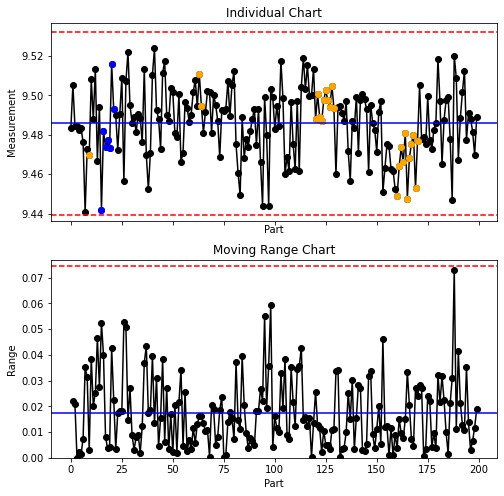

In [14]:
# Check the SPC chart for the measured dimension (common cause variation with batch-to-batch variation)
o = xmr(dim1.loc[:,'measured'])

##### Effect of the tool size variation

In [15]:
# define tool life: how many lots can be processed by one tool
lots_per_tool = 4
# tool tolerance
# Example tool tolerances: http://www.mitsubishicarbide.com/en/technical_information/tec_rotating_tools/face_mills/tec_milling_guide/tec_milling_tolerance
tool_tol = 0.02

In [16]:
# Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
nr_of_tools = int(np.ceil(nr_lots/lots_per_tool))
tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

# add the same adjustment to each part processed by one tool: lots_per_tool * nr_in_lot - lots_per_tool is in number of lots
part = 0
for t in tools:
    for p in range(nr_in_lot * lots_per_tool):
        dim1.loc[part, 'tcv'] = t
        part = part + 1
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

# Sum all the variations:
dim1['measured'] = dim1['ccv'] + dim1['btb'] + dim1['tcv']

<AxesSubplot:>

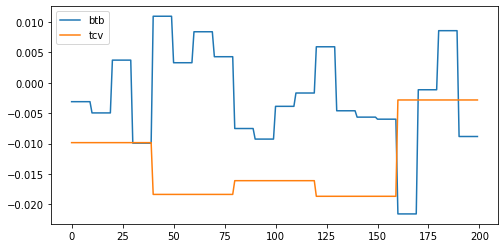

In [17]:
# Compare the impact from batch-to-batch variation with tool-change variation
dim1[['btb','tcv']].plot()

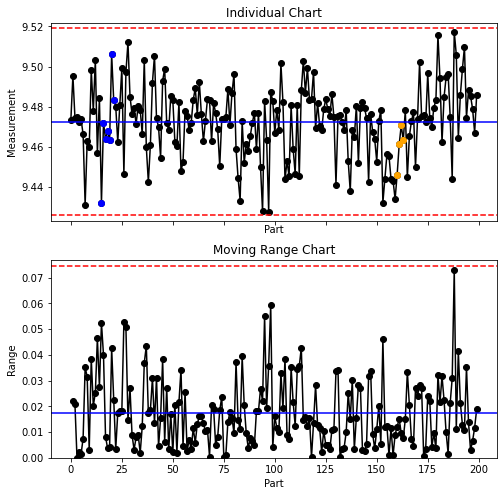

In [18]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = xmr(dim1.loc[:,'measured'])

##### Effect of a tool wear

In [19]:
# Tool wear can be aproximated with a linear model, as per:
# https://www.sciencedirect.com/science/article/pii/S235197891630049X/pdf?md5=de5447dd9c5745bc8a5638dc26d7d66c&pid=1-s2.0-S235197891630049X-main.pdf
# https://journals.sagepub.com/doi/pdf/10.1177/1687814017750434

# Define the maximum tool wear
max_tool_wear = 0.04

In [20]:
# Calculate the tool wear assuming linear tool-wear model
inc_wear = max_tool_wear/(nr_in_lot * lots_per_tool)

part = 0

for t in tools:
    # No tool wear for the firts part
    dim1.loc[part, 't_wear'] = 0
    for p in range(1, nr_in_lot * lots_per_tool):
        part = part + 1
        # pool a random number between 0 and inc_wear and add it to the previous part wear to calculate the total tool wear for current part
        dim1.loc[part, 't_wear'] =  dim1.loc[part-1, 't_wear'] + rng.uniform(0, inc_wear)
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

dim1['measured'] = dim1['ccv'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear']           

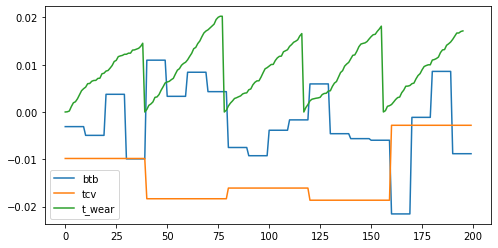

In [21]:
# Compare the impact from batch-to-batch variation, tool-change variation and tool wear
dim1[['btb','tcv', 't_wear']].plot()
plt.show()

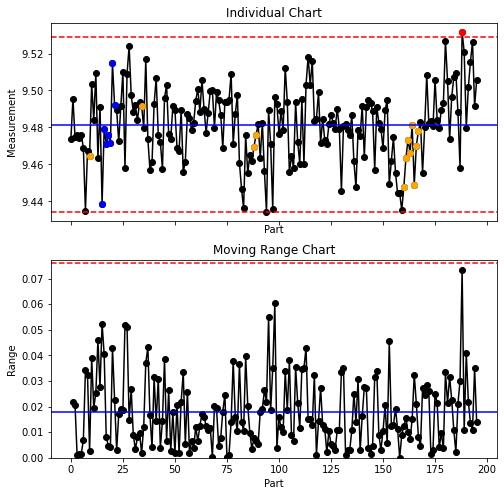

In [22]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = xmr(dim1.loc[:,'measured'])

##### Model tool failure

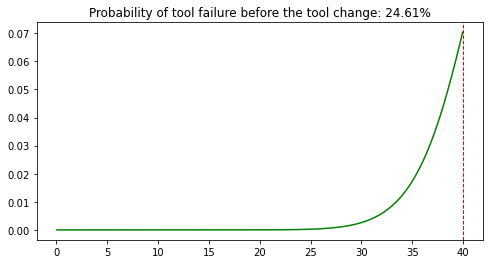

In [23]:
# Model number of parts machined by each tool using Weibull distribution
# https://www.researchgate.net/publication/226636244_Prediction_of_tool_failure_rate_in_turning_hardened_steels

# Shape parameter
a = 12
# scale parameter
lam = nr_in_lot * lots_per_tool  
# location parameter
mu = nr_in_lot * lots_per_tool * 0.1

# Round down to the nearest integer
tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools))

# define the x axis of the plot
x = np.arange(1, 1000.)/1000.*lam

y = weibull_min.pdf(x, a, loc=mu, scale=lam)
plt.plot(x, y, color='green', label='Scaled cdf')
plt.title('Probability of tool failure before the tool change: {:.2%}'.format(weibull_min.cdf(40, a, loc=mu, scale=lam)))
plt.axvline(nr_in_lot * lots_per_tool, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [24]:
tool_life

array([39., 39., 46., 47., 36.])

In [25]:
part = 0

dim1['t_break'] = 0

for tl in tool_life:
    # if tool life is greater than number of parts processed by tool:
    if tl>=nr_in_lot * lots_per_tool:
        part = part + nr_in_lot * lots_per_tool
        if part>=nr_lots*nr_in_lot:
            break        
    # if tool life is smaller than number of parts processed by tool:
    else:
        part = part + int(tl)
        if part>=nr_lots*nr_in_lot:
            break        
        for p in range(int(tl), nr_in_lot * lots_per_tool):
            # Assign random value from normal distribution centered around 0.1
            # Chipped cutting tool will have smaller size causing large shift in the machined size
            # but rougher edge will introduce more variation to the process
            dim1.loc[part, 't_break'] = rng.normal(0.1, 0.01)
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reaches nr_lots*nr_in_lot
            if part>=nr_lots*nr_in_lot:
                break
                
dim1['measured'] = dim1['ccv'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear'] + dim1['t_break']     

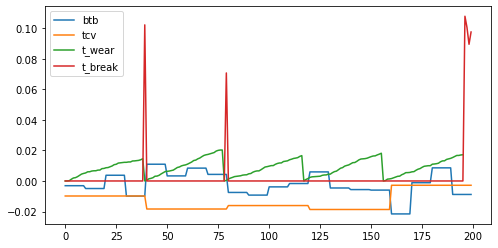

In [26]:
# Compare the impact from batch-to-batch variation, tool-change variation, tool wear and tool failure
dim1[['btb','tcv', 't_wear', 't_break']].plot()
plt.show()

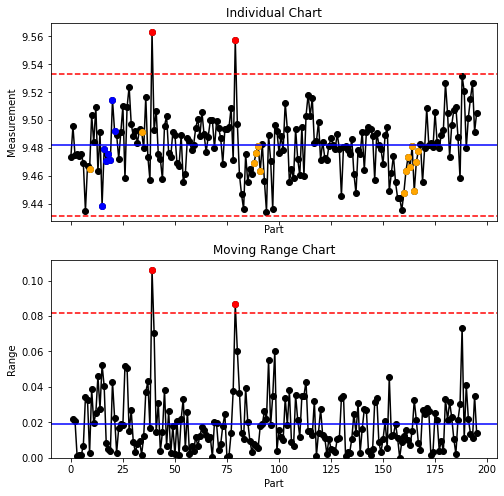

In [27]:
# Check the SPC chart for the measured dimension
o = xmr(dim1.loc[:,'measured'])

<a id="par3.1"></a>
### 3.2 Simulate 10 independent variables

##### Define process step parameters

In [28]:
# Number of days
n_days = 30
# Numbers of batches (lots) manufactured in one day
nr_lots = 20
# Parts in a lot 
parts_in_lot = 10
# Total number of parts
n_parts = n_days* nr_lots * parts_in_lot

#### 3.2.1 Create a table of process definitions

In [29]:
# Create a table of 10 process definitions:
# Number of independent variables to be simulated:
n_dim = 10

# list of typical tolerances used in manufacturing process and their typical frequency of use
tol_array = [0.02, 0.05, 0.10, 0.20]
tol_freq =  [0.10, 0.20, 0.50, 0.20]

dim_def = pd.DataFrame({'Nominal': np.round(rng.uniform(3, 10, n_dim), 1) })
dim_def['tolerance'] = rng.choice(tol_array, n_dim, p=tol_freq )
dim_def['LSL'] = dim_def['Nominal']-dim_def['tolerance']
dim_def['USL'] = dim_def['Nominal']+dim_def['tolerance']

dim_def['Cp'] = rng.normal(2, 0.5, n_dim)

# number of parts made by single tool will be pooled from natural numbers between 1 and 9:
dim_def['lots_per_tool'] = rng.choice(range(1,10), n_dim)

# tool lolerance will be randomly selected from th efollowing list:
dim_def['tool_tol '] = rng.choice([0.01, 0.02, 0.04], n_dim)

# max tool wear per tool
dim_def['max_tool_wear'] = rng.choice([0.01, 0.02, 0.04], n_dim)





# Tool failure probability from Webul distribution
a = 12
dim_def['tool_weibul_a'] = a
dim_def['tool_weibul_loc'] = parts_in_lot * dim_def['lots_per_tool'] * rng.uniform(0.1, 0.3, n_dim)
dim_def['tool_weibul_scale'] = parts_in_lot * dim_def['lots_per_tool']
dim_def['tool_failure_prob'] = weibull_min.cdf(parts_in_lot * dim_def['lots_per_tool'], a, loc=dim_def['tool_weibul_loc'], scale=dim_def['tool_weibul_scale'])

dim_def

,Nominal,tolerance,LSL,USL,Cp,lots_per_tool,tool_tol,max_tool_wear,tool_weibul_a,tool_weibul_loc,tool_weibul_scale,tool_failure_prob
0,5.7,0.02,5.68,5.72,1.611316,7,0.01,0.04,12,18.409892,70,0.025355
1,3.1,0.10,3.00,3.20,2.222916,2,0.02,0.02,12,4.655541,20,0.040743
2,5.3,0.10,5.20,5.40,1.076741,3,0.04,0.02,12,5.182063,30,0.097637
3,8.5,0.10,8.40,8.60,1.980667,7,0.02,0.04,12,15.169907,70,0.051942
4,4.0,0.10,3.90,4.10,2.395798,5,0.01,0.01,12,13.234632,50,0.024673
5,3.3,0.10,3.20,3.40,1.952027,5,0.01,0.01,12,5.067469,50,0.242241
6,7.1,0.10,7.00,7.20,2.206545,3,0.04,0.02,12,6.999228,30,0.040414
7,4.9,0.10,4.80,5.00,1.602926,3,0.04,0.01,12,3.635352,30,0.191222
8,5.6,0.10,5.50,5.70,1.214160,8,0.04,0.02,12,23.948192,80,0.013898
9,3.3,0.20,3.10,3.50,2.200100,2,0.04,0.04,12,3.859026,20,0.073506


####  3.2.2 Create a table with dimension measurements for all the features

##### Prepare DataFrame to hold all the measurements

In [30]:
# Create an all_dims Dataframe with a first columns: 'Date' and 'Lot'

days = []
lots = []

for day in range(n_days):
    for lot in range(nr_lots):        
        for part in range(parts_in_lot):
            # There will be 'parts_in_lot * nr_lots' parts made in every day, all these rows will have the same value in the 'Date' column
            days.append(day)
            # Make sure that lot number is unique for every batch
            lots.append(day*nr_lots + lot)
        
all_dims = pd.DataFrame({'Date': days, 'Lot': lots})

In [31]:
# Create a DataFrame to keep all the parameters for each lot and dimension
lot_parameters = pd.DataFrame({'Lot': all_dims['Lot'].unique()})
lot_parameters.set_index('Lot', inplace=True)

In [32]:
# Simulate the n_dim number of features processed over n_days days:

all_parts = nr_lots*parts_in_lot*n_days

dim = pd.DataFrame(all_dims['Lot'])

# Iterate through the columns of all_dims DataFrame:
for dim_row, index in dim_def.iterrows():
    column = "Dim" + str(dim_row + 1)
    mean = index[0]
    tol = index[1] * 2
    cp = index[4]
    # Tool parameters:
    lots_per_tool = int(index[5])
    tool_tol = index[6]
    max_tool_wear = index[7]
    # Tool failure Weibull distribution parameters
    # Shape parameter
    a = index[8]
    # scale parameter
    mu = index[9]
    # location parameter
    lam = index[10]
    
    # Simulate the effect of proces not being centered at the nominal
    # The mean of such process would be pooled from normal distribution:
    proc_mean=rng.normal(mean, tol/6)
    
    dim['ccv'] = rng.normal(proc_mean, tol/(6*cp) , n_parts)
    #dim = pd.DataFrame({'ccv': rng.normal(proc_mean, tol/(6*cp) , n_parts)})
    
    # ADD BATCH TO BATCH VARIATION
    
    # define the ratio of batch-to-batch standard deviation to the dimension tolerance
    # The larger the number, the smallest the effect of this special cause 
    btb_sd_ratio = rng.normal(20, 5)

    # create an array with adjustment for mean for each lot
    lots = rng.normal(0, tol/btb_sd_ratio , nr_lots * n_days)
    
    #add the values of the batch to batch variation to lot_parameters DataFrame    
    col='btb'+str(dim_row + 1)
    lot_parameters[col] = lots
    

    # add the same adjustment for each 'parts_in_lot' in a lot
    part = 0
    for l in lots:
        for p in range(parts_in_lot):
            dim.loc[part, 'btb'] = l
            part = part + 1            

            
    #ADD TOOL CHANGE VARIATION and EFFECT OF A TOOL WEAR
    
    # Calculate the tool wear assuming linear tool-wear model
    inc_wear = max_tool_wear/(nr_in_lot * lots_per_tool)
    
    # Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
    nr_of_tools = int(np.ceil(nr_lots * n_days/lots_per_tool))
    tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

    # add tool variation parameter to lot_parameter DataFrame
    tw = pd.DataFrame({'tcv': tools})
    # as per https://stackoverflow.com/questions/49074021/repeat-rows-in-data-frame-n-times
    tw = tw.loc[tw.index.repeat(lots_per_tool)].reset_index(drop=True)
    
    col='tcv'+str(dim_row + 1)
    lot_parameters[col] = tw.iloc[:,0]
    
    part = 0
    for t in tools:
        # No tool wear for the firts part processed by given tool
        dim.loc[part, 't_wear'] = 0
        for p in range(parts_in_lot * lots_per_tool):
            dim.loc[part, 'tcv'] = t           
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reachesall_parts = nr_lots*parts_in_lot*n_days
            if part==all_parts:
                break
            dim.loc[part, 't_wear'] =  dim.loc[part-1, 't_wear'] + rng.uniform(0, inc_wear) 
    
    
    
    # ADD EFFECT OF EARLY TOOL FAILURE


    # tool_life: number of processed part before tool failure, rounded down to the nearest integer:
    tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools))
    # initialize 't_break' column with all 0s
    dim['t_break'] = 0  
    
    # reset the part count
    part = 0
    for tl in tool_life:
        # if tool life is greater than number of parts processed by tool:
        if tl>=parts_in_lot * lots_per_tool:
            # increase the part count by number of parts processed by the tool
            part = part + parts_in_lot * lots_per_tool
            if part>=nr_lots*nr_in_lot:
                break        
        # if tool life is smaller than number of parts processed by tool:
        else:
            part = part + int(tl)
            if part>=nr_lots*nr_in_lot:
                break
            # Step through all the parts from in the range from tool Life to maximum processed by the tool    
            for p in range(int(tl), nr_in_lot * lots_per_tool):
                # Assign random value from normal distribution centered around 0.1
                # Chipped cutting tool will have smaller size causing large shift in the machined size
                # but rougher edge will introduce more variation to the process
                dim.loc[part, 't_break'] = rng.normal(0.1, 0.01)
                part = part + 1
                # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
                # exiting the loop when part count reaches nr_lots*nr_in_lot
                if part>=nr_lots*nr_in_lot:
                    break
    
    #add True to t_break column if Lot has parts machined with broken tool    
    col='t_break'+str(dim_row + 1)
    lot_parameters[col] = dim.groupby('Lot')['t_break'].sum()>0
    
    # ADD EFFECT OF COMMON CAUSES VARIATION AND ALL SPECIAL CAUSES 

    # Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
    all_dims[column] = dim['ccv'] + dim['btb'] + dim['tcv'] + dim['t_wear'] + dim['t_break']
    
    
    
all_dims    

,Date,Lot,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,Dim8,Dim9,Dim10
0,0,0,5.702433,3.078786,5.303420,8.446135,3.980966,3.270605,7.059401,4.869246,5.595174,3.229105
1,0,0,5.704152,3.081547,5.267835,8.483186,3.976757,3.306411,7.063470,4.884502,5.655504,3.273099
2,0,0,5.713809,3.090193,5.246989,8.459124,4.015418,3.275625,7.057698,4.861229,5.676809,3.243448
3,0,0,5.706797,3.102646,5.292688,8.494251,3.982949,3.287605,7.058452,4.859981,5.680615,3.238660
4,0,0,5.706902,3.089366,5.301164,8.472549,3.987388,3.271708,7.050356,4.869499,5.627840,3.228661
...,...,...,...,...,...,...,...,...,...,...,...,...
5995,29,599,5.712743,3.088982,5.343042,8.487254,4.045550,3.314699,7.033328,4.891995,5.640814,3.268753
5996,29,599,5.711172,3.098693,5.334197,8.469163,4.044112,3.290952,7.025012,4.874371,5.635535,3.347428
5997,29,599,5.715014,3.081988,5.347348,8.486906,4.038662,3.295674,7.031448,4.910152,5.609168,3.316163
5998,29,599,5.715283,3.107202,5.346084,8.476990,4.049451,3.328548,7.048758,4.853806,5.548752,3.298480


In [33]:
lot_parameters

,btb1,tcv1,t_break1,btb2,tcv2,t_break2,btb3,tcv3,t_break3,btb4,...,t_break7,btb8,tcv8,t_break8,btb9,tcv9,t_break9,btb10,tcv10,t_break10
Lot,,,,,,,,,,,,,,,,,,,,,
0,0.000547,-0.001799,False,0.002104,-0.011839,False,-0.004501,-0.038168,False,0.000137,...,False,-0.012991,-0.025047,False,-0.003899,-0.003217,False,0.005088,-0.037121,False
1,-0.001401,-0.001799,False,-0.002098,-0.011839,False,-0.017984,-0.038168,False,0.006947,...,False,-0.011466,-0.025047,False,0.020497,-0.003217,False,-0.048182,-0.037121,True
2,0.003104,-0.001799,False,-0.019564,-0.015041,False,0.011500,-0.038168,False,-0.004840,...,False,-0.004024,-0.025047,False,-0.018227,-0.003217,False,0.024020,-0.011049,False
3,0.001298,-0.001799,False,0.004458,-0.015041,True,-0.030485,-0.031353,False,-0.005920,...,False,0.003233,-0.013036,False,0.013469,-0.003217,False,-0.019702,-0.011049,False
4,0.000647,-0.001799,False,-0.008146,-0.003564,False,0.005520,-0.031353,False,0.002956,...,False,-0.000370,-0.013036,False,0.002015,-0.003217,False,-0.047872,-0.000553,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001015,-0.004695,False,0.017433,-0.008523,False,-0.003683,-0.022792,False,-0.005963,...,False,-0.005039,-0.007944,False,0.010607,-0.033662,False,-0.040606,-0.028638,False
596,-0.000738,-0.004695,False,-0.011258,-0.018692,False,0.027987,-0.022792,False,-0.011323,...,False,-0.005023,-0.007944,False,0.002591,-0.033662,False,-0.025303,-0.034891,False
597,-0.000180,-0.004695,False,-0.001042,-0.018692,False,0.004026,-0.034034,False,0.010589,...,False,0.003976,-0.012832,False,0.013891,-0.033662,False,0.054473,-0.034891,False


In [34]:
# Check if any of the 10 dimensions in each part is outside of tolerance band
# Mark part as scrap if at least one dimension is outside of tolerance

all_dims['Scrap_all'] = False
for row, index in dim_def.iterrows():
    # Iterate through dim_def table and set the Upper and Lower Service Limits
    lsl = dim_def.iloc[row, 2]
    usl = dim_def.iloc[row, 3]
    # Compare the measurement (column by column from all_dims) against the Service Limits
    all_dims['Scrap' + str(row+1)] = (lsl > all_dims['Dim'+str(row+1)]) | (all_dims['Dim'+str(row+1)] > usl)
    all_dims['Scrap_all'] = all_dims['Scrap_all'] | all_dims['Scrap' + str(row+1)]

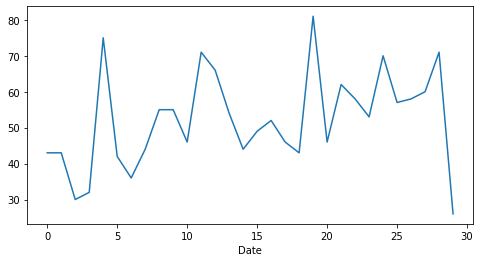

In [35]:
# Visualise amount of scraped part in every day
all_dims.groupby('Date').sum()['Scrap_all'].plot()
plt.show()

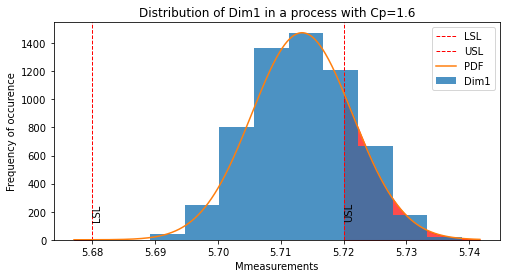

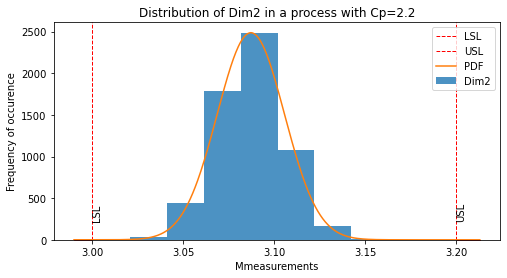

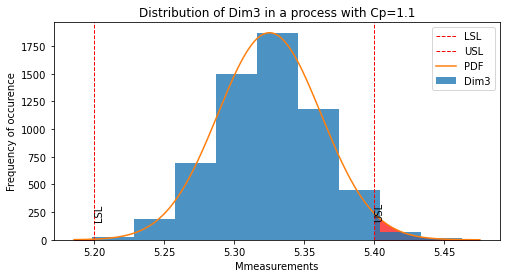

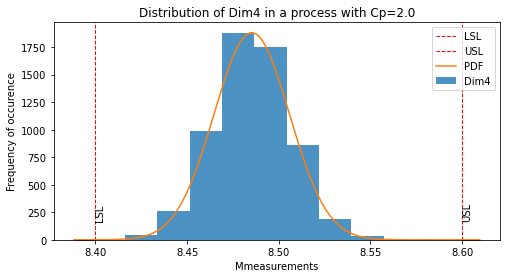

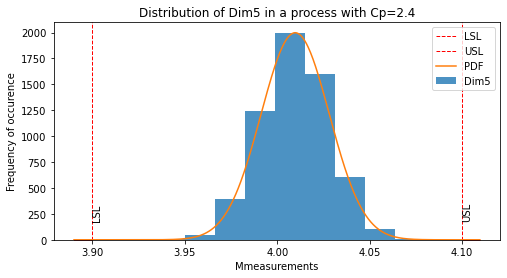

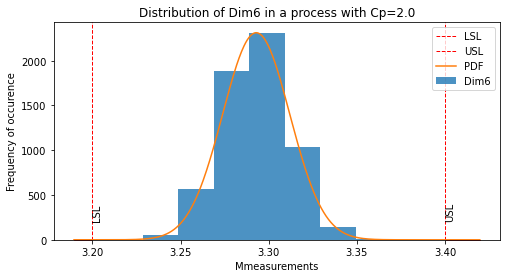

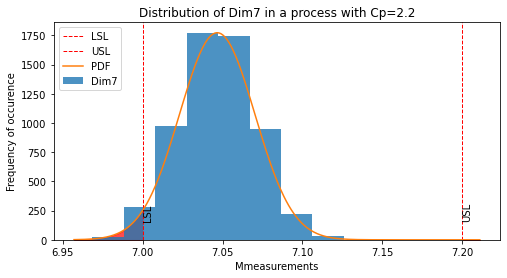

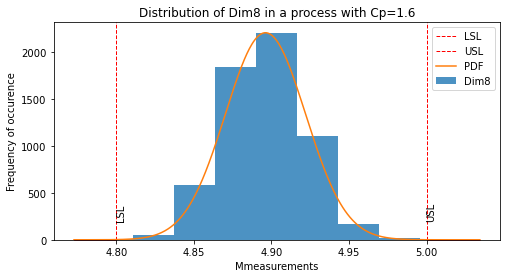

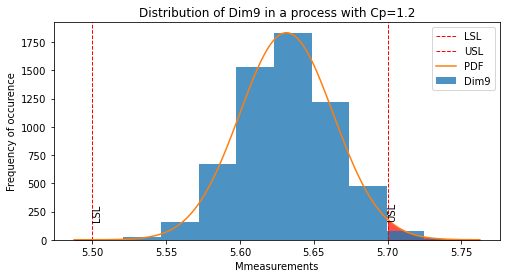

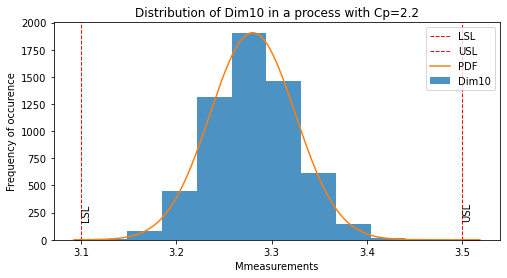

In [36]:
# Show all the dimensions distribution on histogram with LSL and USL marked
for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    hist(all_dims[column], column, dim_def.loc[row,'LSL'], dim_def.loc[row,'USL'], dim_def.loc[row,'Cp'])

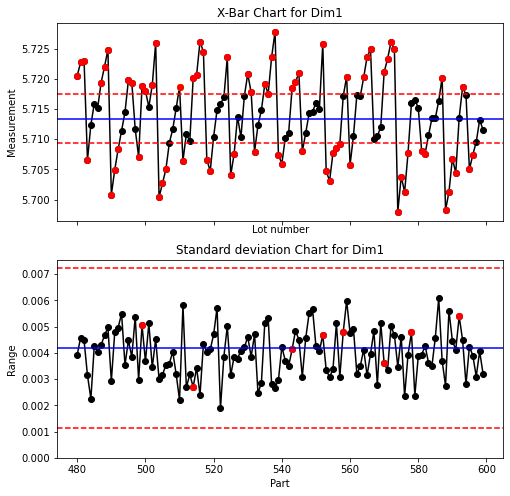

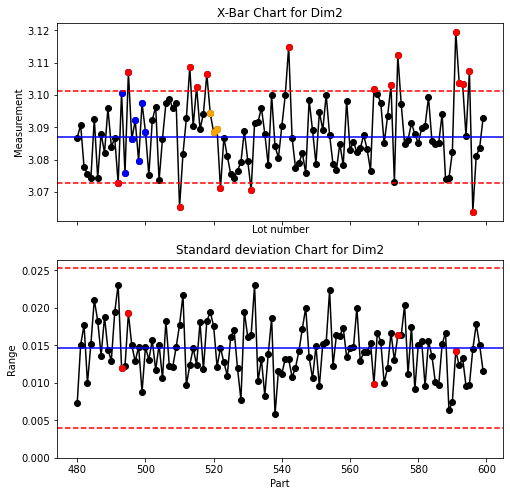

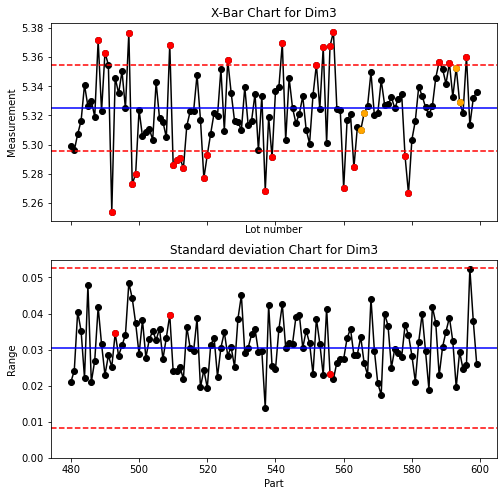

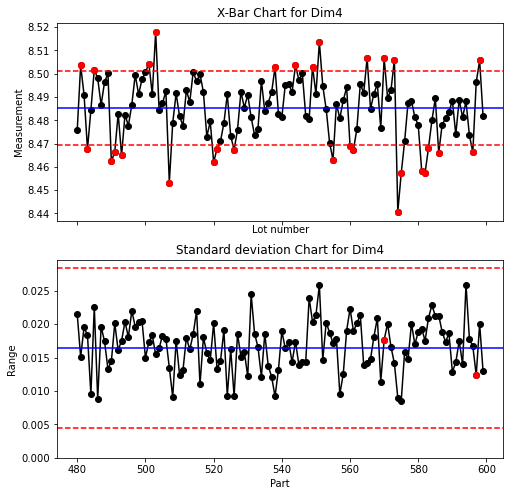

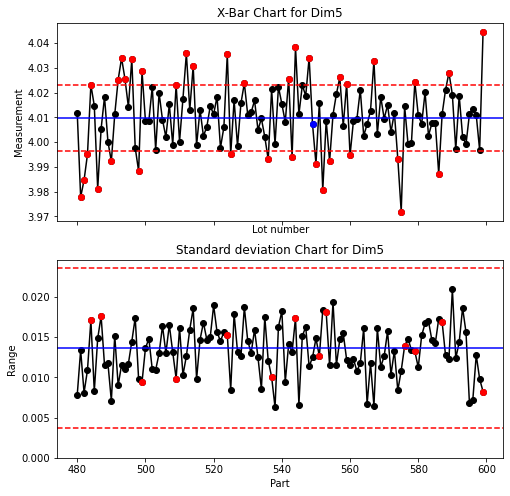

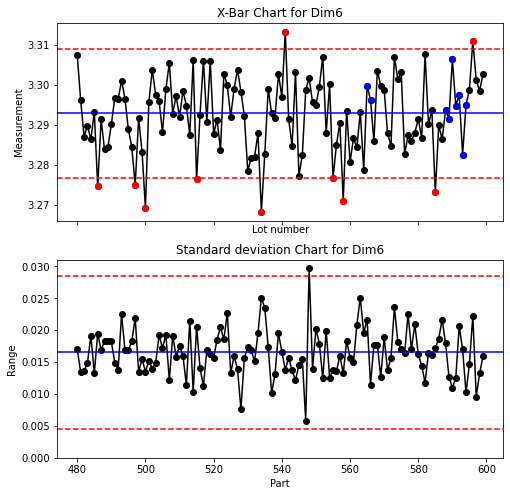

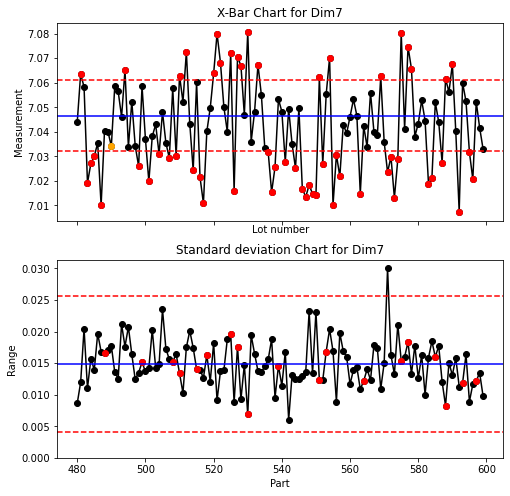

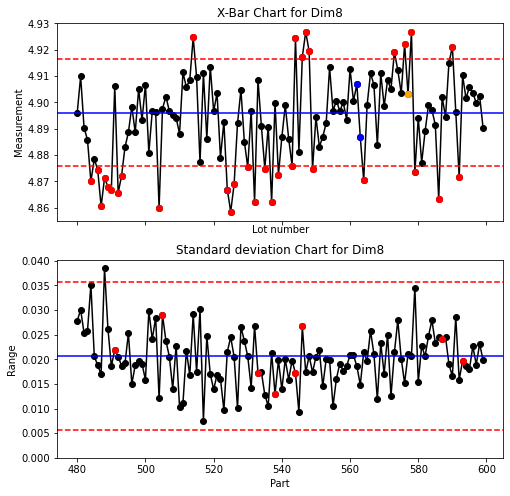

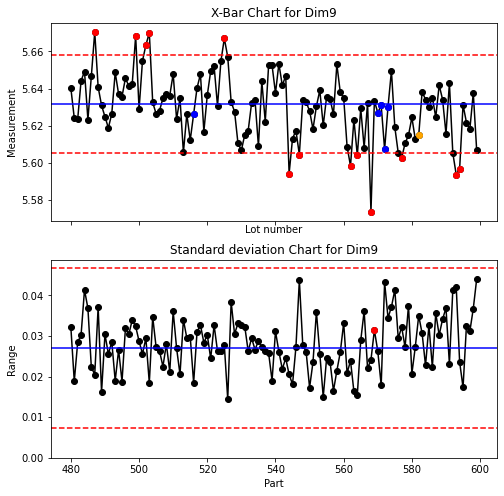

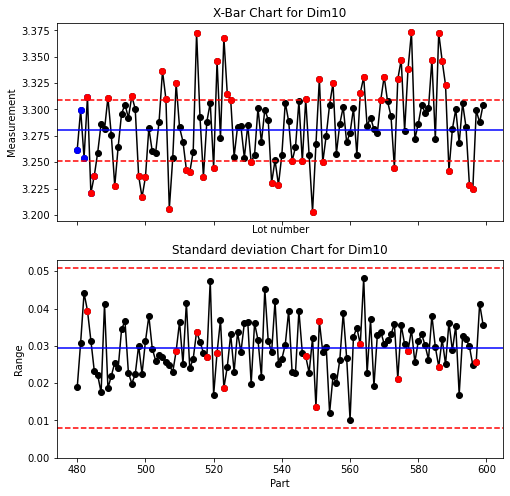

In [37]:
# Show all the dimensions run charts with their Upper and Lower SPC control limits
# Highlight the points that violate one of the SPC rules
for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    xb = xBarS(all_dims, column, 120)
    lot_parameters["St_dev"+str(row + 1)] = xb['variability']
    lot_parameters["SPC_Rule"+str(row + 1)] = xb['Reason']

In [40]:
lot_parameters

,btb1,tcv1,t_break1,btb2,tcv2,t_break2,btb3,tcv3,t_break3,btb4,...,St_dev6,SPC_Rule6,St_dev7,SPC_Rule7,St_dev8,SPC_Rule8,St_dev9,SPC_Rule9,St_dev10,SPC_Rule10
Lot,,,,,,,,,,,,,,,,,,,,,
0,0.000547,-0.001799,False,0.002104,-0.011839,False,-0.004501,-0.038168,False,0.000137,...,0.014899,00000,0.008918,00000,0.029598,00001,0.033463,00000,0.024080,00001
1,-0.001401,-0.001799,False,-0.002098,-0.011839,False,-0.017984,-0.038168,False,0.006947,...,0.017753,00000,0.016303,00001,0.015042,00000,0.029354,00001,0.051142,00001
2,0.003104,-0.001799,False,-0.019564,-0.015041,False,0.011500,-0.038168,False,-0.004840,...,0.017428,00000,0.010050,00000,0.018440,00000,0.020024,00000,0.024524,00011
3,0.001298,-0.001799,False,0.004458,-0.015041,True,-0.030485,-0.031353,False,-0.005920,...,0.016161,00000,0.013498,00000,0.019525,00001,0.026678,00000,0.019832,00000
4,0.000647,-0.001799,False,-0.008146,-0.003564,False,0.005520,-0.031353,False,0.002956,...,0.012821,00000,0.011978,00001,0.032574,00001,0.031879,00000,0.033166,00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001015,-0.004695,False,0.017433,-0.008523,False,-0.003683,-0.022792,False,-0.005963,...,0.014657,00000,0.008905,00001,0.017987,00000,0.017339,00000,0.029852,00001
596,-0.000738,-0.004695,False,-0.011258,-0.018692,False,0.027987,-0.022792,False,-0.011323,...,0.022270,00001,0.011665,00001,0.022619,00000,0.032522,00000,0.024806,00001
597,-0.000180,-0.004695,False,-0.001042,-0.018692,False,0.004026,-0.034034,False,0.010589,...,0.009581,00000,0.012204,00010,0.018942,00000,0.031164,00000,0.025778,00010


<a id="par4"></a>
## 4. Analyse the data

## 5. References

[[1] VARIABILITY IN MANUFACTURING](https://link.springer.com/referenceworkentry/10.1007%2F1-4020-0612-8_1032#Chap1031_1-4020-0612-8_1031)<br>

# End